<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/16_music_classification_light_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация музыки по жанрам

**Задание light:**

Для базы GTZAN Genre Collection
1. Сделать классификацию с помощью полносвязной нейронной сети. Найти оптимальную архитектуру (количество слоев и нейронов) и оптимальный набор гипермапараметров (оптимизатор, размер мини-выборки, количество эпох и т.д.).
2. Используя библиотеку librosa (http://librosa.github.io/librosa/feature.html) поварьировать набор признаков, извлекаемых из аудио-файла. В качестве примера некоторые параметры можно вычислять не от всего файла длительностью 30 секунд, а от его частей, например длительностью 10 секунд. Также можно обратить внимание на количество mfcc коэффициентов.
3. (Опционально) Применить линейные модели (решающие деревья, градиентный бустинг) из библиотеки sklearn на полученном датасете, сделать ансамбль моделей из нейросети и линейных моделей.
 
**Задание pro:**
1. Выполните задание light.
2. Получите визуальные представления аудио файлов (возможно длительности менее 30 секунд).
3. Постройте модель классификации с использованием сверточных сетей. 
Удалось ли превзойти полносвязные сети?

# Подготовка окружения

In [0]:
# feature extractoring and preprocessing data
import librosa
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#matplotlib inline
import os
import PIL
from IPython.display import display
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing import image

# Google
from google.colab import files
from google.colab import drive


#Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

slice_duration = 5
features_file = f"sound_features_{slice_duration}sec.csv"

## Подключение Google Drive

In [2]:
drive.mount('/content/drive')
#http://marsyas.info/downloads/datasets.html

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Загрузка наборов данных

In [0]:
!cp /content/drive/'My Drive'/neural/genres.zip genres.zip
!unzip genres.zip

## Утилиты

In [0]:
def append_features_header(header, feature_name):
    if (feature_name == "mfcc"):
        header = np.append(header, np.vectorize(lambda i: f'mfcc{i}')(np.arange(1, 21)))
    elif (feature_name == "tonnetz"):
        header = np.append(header, np.vectorize(lambda i: f'tonnetz{i}')(np.arange(1, 7)))
    elif (feature_name == "chroma_cqt"):
        header = np.append(header, np.vectorize(lambda i: f'chroma_cqt{i}')(np.arange(1, 13)))
    else:
        header = np.append(header, feature_name)
    return header
    
def create_features_header(features):
    header = ["filename"]
    for feature_name in features:
        header = append_features_header(header, feature_name)
    header = np.append(header, 'label')
    return header

def get_feature_by_name(feature_name, y, sr):
    if feature_name == "chroma_stft":
        return librosa.feature.chroma_stft(y=y, sr=sr)
    elif feature_name == "rmse":
        return librosa.feature.rmse(y=y)
    elif feature_name == "spectral_centroid":
        return librosa.feature.spectral_centroid(y=y, sr=sr)
    elif feature_name == "spectral_bandwidth":
        return librosa.feature.spectral_bandwidth(y=y, sr=sr)
    elif feature_name == "rolloff":
        return librosa.feature.spectral_rolloff(y=y, sr=sr)
    elif feature_name == "zero_crossing_rate":
        return librosa.feature.zero_crossing_rate(y)
    elif feature_name == "mfcc":
        return librosa.feature.mfcc(y=y, sr=sr)
    elif feature_name == 'spectral_flatness':
        return librosa.feature.spectral_flatness(y = y)
    elif feature_name == 'tonnetz':
        return librosa.feature.tonnetz(y=y, sr=sr)
    elif feature_name == 'tempogram':
        return librosa.feature.tempogram(y=y, sr=sr)
    elif feature_name == 'chroma_cqt':
        return librosa.feature.chroma_cqt(y=y, sr=sr)
    elif feature_name == 'melspectrogram':
        return librosa.feature.melspectrogram(y=y, sr=sr)
    else:
        print("Incorrect feature: ", feature_name)
        
def prepare_feature_value(feature_name, feature_value):
#     print(f'{feature_name} value shape: {feature_value.shape})')
    if (feature_name in ['mfcc', 'tonnetz', 'chroma_cqt']):
        return np.apply_along_axis(lambda x: np.mean(x), 1, feature_value)
    else:
        return np.mean(feature_value)
        
def get_features(y, sr, features):
    features_values = []
    for feature_name in features:
        feature = get_feature_by_name(feature_name, y, sr)
        value = prepare_feature_value(feature_name, feature)
        features_values = np.append(features_values, value)
    return features_values


## Формирование датасета с характеристиками звука

In [44]:
print(header)

['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'label']


In [5]:
features = ['chroma_stft', 
            'rmse',
            'tonnetz',
            'spectral_centroid', 
            'spectral_bandwidth', 
            'spectral_flatness', 
            'rolloff', 
            'zero_crossing_rate', 
            'chroma_cqt',
            'melspectrogram',
            'tempogram',
            'mfcc'
]
header = create_features_header(features)
file = open(features_file, 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
parts = np.arange(0, 30 // slice_duration)

file = open(features_file, 'a', newline='')
with file:
    writer = csv.writer(file)

    for genre in genres:
        dir_content = os.listdir(f'./genres/{genre}')
        i = 1
        n = len(dir_content)
        print()
        for filename in dir_content:
            songname = f'./genres/{genre}/{filename}'
            print("\r", end = f'{genre}: {i} of {n}')
            i += 1
            
            for part in parts:
                y, sr = librosa.load(songname, mono=True, offset = part * slice_duration, duration=slice_duration)

                row = [f"{filename}, {part * slice_duration}"]
                row = np.append(row, get_features(y, sr, features))
                row = np.append(row, genre)
                writer.writerow(row)
    print()


blues: 100 of 100
classical: 100 of 100
country: 100 of 100
disco: 100 of 100
hiphop: 100 of 100
jazz: 100 of 100
metal: 100 of 100
pop: 100 of 100
reggae: 100 of 100
rock: 100 of 100


## Загрузка датасета с характеристиками звука

In [38]:
features = create_features_header(['chroma_stft', 
            'rmse',
            'tonnetz',
            'spectral_centroid', 
            'spectral_bandwidth', 
            'spectral_flatness', 
            'rolloff', 
            'zero_crossing_rate', 
            'chroma_cqt',
            'melspectrogram',
            'tempogram',
            'mfcc'
])

data = pd.read_csv(features_file)
data = data[features]

print(data.shape)
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
data = data.drop(['label'],axis=1)

#Scaling the Feature columns
scaler = StandardScaler()

X = scaler.fit_transform(np.array(data.iloc[:, :], dtype = float))

#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

print("Train set: ", X_train.shape)
print("Test set: ", X_test.shape)

(6000, 49)
Train set:  (5700, 47)
Test set:  (300, 47)


In [39]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

# Подготовка классификаторов

## Классификация методами машинного обучения

In [0]:
from sklearn import metrics

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [146]:
# bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100)

forest = RandomForestClassifier(n_estimators=100, random_state=3)
bdt = AdaBoostClassifier(forest, n_estimators=50)

multi_target_forest = MultiOutputClassifier(bdt, n_jobs=1)
classifier = multi_target_forest.fit(X_train, y_train_ohe)

test_predictions = classifier.predict(X_test)
acc = metrics.accuracy_score(y_test_ohe, test_predictions)
      
print("Accuracy: ", acc)

Accuracy:  0.5466666666666666


## Классификация с помощью нейросети

In [12]:
# Коллбэки
model_callbacks = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-6, verbose=1)
]

optimizer = Adam(lr=0.01)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer="glorot_uniform"))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs = 30,
                    batch_size = 16,
                    validation_split = 0.1,
                    callbacks = model_callbacks)

Train on 5130 samples, validate on 570 samples
Epoch 1/30
5130/5130 [==============================] - 1s 202us/sample - loss: 1.2726 - acc: 0.5811 - val_loss: 0.9586 - val_acc: 0.6702
Epoch 2/30
5130/5130 [==============================] - 1s 172us/sample - loss: 0.9715 - acc: 0.6949 - val_loss: 0.9272 - val_acc: 0.7035
Epoch 3/30
5130/5130 [==============================] - 1s 171us/sample - loss: 0.8558 - acc: 0.7292 - val_loss: 0.8743 - val_acc: 0.7105
Epoch 4/30
5130/5130 [==============================] - 1s 172us/sample - loss: 0.7653 - acc: 0.7686 - val_loss: 0.8577 - val_acc: 0.7561
Epoch 5/30
5130/5130 [==============================] - 1s 173us/sample - loss: 0.6577 - acc: 0.7953 - val_loss: 0.7461 - val_acc: 0.7684
Epoch 6/30
5130/5130 [==============================] - 1s 171us/sample - loss: 0.6272 - acc: 0.8129 - val_loss: 0.6605 - val_acc: 0.8193
Epoch 7/30
5130/5130 [==============================] - 1s 169us/sample - loss: 0.5620 - acc: 0.8363 - val_loss: 0.8799 - val

### График обучения

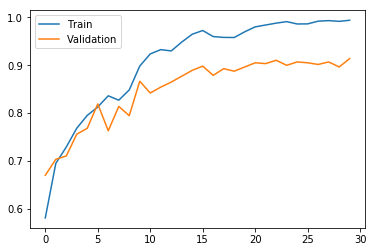

In [13]:
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.legend()
plt.show()

### Проверка на тестовой выборке

In [14]:
result = model.evaluate(X_test, y_test)
print(result)

300/300 [==============================] - 0s 58us/sample - loss: 0.4990 - acc: 0.8933
[0.49899046262105307, 0.8933333]


### Визуальное представление нейросети

In [124]:
from keras.utils import plot_model
plot_model(model, to_file='genres_dense.png', show_layer_names=False, show_shapes=True)

Using TensorFlow backend.


### Подбор параметров (сомнительный)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

test_fold = []
print(len(y_train))
for i in range(len(y_train) * 9 // 10):
    test_fold.append(-1)
print(len(test_fold))
for i in range(len(y_train) // 10):
    test_fold.append(0)

print(len(test_fold))
    
ps = PredefinedSplit(test_fold)

def create_model(optimizer = "adam", init = "glorot_uniform"):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X.shape[1],), kernel_initializer=init))
    model.add(Dropout(0.3))
#     model.add(Dense(128, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

estimator = KerasClassifier(build_fn=create_model)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
# optimizers = ['adam']
epochs = [50]
batches = [16, 32, 64]
init = ['glorot_uniform', 'normal', 'uniform']
# init = ['glorot_uniform']

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='balanced_accuracy', cv=ps)

grid_result = grid.fit(X_train, y_train)

5700
5130
5700
Epoch 1/50
5130/5130 [==============================] - 1s 222us/sample - loss: 1.6470 - acc: 0.4131
Epoch 2/50
5130/5130 [==============================] - 1s 210us/sample - loss: 1.3391 - acc: 0.5212
Epoch 3/50
5130/5130 [==============================] - 1s 218us/sample - loss: 1.2532 - acc: 0.5509
Epoch 4/50
5130/5130 [==============================] - 1s 220us/sample - loss: 1.2003 - acc: 0.5688
Epoch 5/50
5130/5130 [==============================] - 1s 218us/sample - loss: 1.1533 - acc: 0.5924
Epoch 6/50
5130/5130 [==============================] - 1s 220us/sample - loss: 1.1174 - acc: 0.5992
Epoch 7/50
5130/5130 [==============================] - 1s 228us/sample - loss: 1.0787 - acc: 0.6209
Epoch 8/50
5130/5130 [==============================] - 1s 229us/sample - loss: 1.0546 - acc: 0.6242
Epoch 9/50
5130/5130 [==============================] - 1s 224us/sample - loss: 1.0374 - acc: 0.6402
Epoch 10/50
5130/5130 [==============================] - 1s 221us/sample - l

In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.755136 using {'batch_size': 16, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}


# Демонстрация работы классификатора

## Применение нейросети для звукового файла произвольной длины

In [0]:
def detect_file_genre(demo_filename):
    print(f"--- {demo_filename} ---")
    # получаем звуковые параметры на 5-секундных интервалах
    demo_features = ['chroma_stft', 
                'rmse',
                'tonnetz',
                'spectral_centroid', 
                'spectral_bandwidth', 
                'spectral_flatness', 
                'rolloff', 
                'zero_crossing_rate', 
                'chroma_cqt',
                'melspectrogram',
                'tempogram',
                'mfcc']

    duration = librosa.get_duration(filename = demo_filename)
    intervals = range(0, int(duration // slice_duration))
    intervals_count = len(intervals)
    print(f"Duration {duration} sec: {intervals_count} intervals")
    X = []
    for i in intervals:
        print("\r", end = f'Interval {i + 1} of {intervals_count}')
        y, sr = librosa.load(demo_filename, mono=True, offset = i * slice_duration, duration=slice_duration)
        row = get_features(y, sr, demo_features)
        X.append(row)

    # нормализуем теми же значениями, что и тренировочный набор данных
    X = scaler.transform(X)

    # классифицируем
    prediction = model.predict(X)
    prediction = np.argmax(prediction, axis=1)

    # разбираем результат
    unique, counts = np.unique(prediction, return_counts = True)

    result = list(zip(-counts, -unique))
    result = -np.sort(result, axis=0)
    print(f"\n\n--- Classification ---")
    for r in result:
        sure = r[0] * 100 // intervals_count
        genre = genres[r[1]]
        print(f"{sure}% – {genre}")


## Примеры классификации

### Sabaton – Primo Victoria

In [113]:
detect_file_genre("Sabaton  - Primo Victoria.mp3")

--- Sabaton  - Primo Victoria.mp3 ---
Duration 272.3 sec: 54 intervals
Interval 54 of 54

--- Classification ---
42% – rock
24% – metal
22% – hiphop
5% – disco
3% – country
1% – classical


### Louis Armstrong – Go Down Moses

In [109]:
detect_file_genre("Louis Armstrong-Go Down Moses.mp3")

--- Louis Armstrong-Go Down Moses.mp3 ---
Duration 220.8 sec: 44 intervals
Interval 44 of 44

--- Classification ---
29% – rock
27% – reggae
15% – jazz
9% – hiphop
6% – disco
6% – country
4% – classical


### AC/DC – Thunderstuck

In [114]:
detect_file_genre("ACDC - Thunderstruck.mp3")

--- ACDC - Thunderstruck.mp3 ---
Duration 174.7 sec: 34 intervals
Interval 34 of 34

--- Classification ---
35% – rock
23% – reggae
20% – metal
17% – hiphop
2% – country


### Sting - Englishman In New York

In [110]:
detect_file_genre("Sting - Englishman In New York.mp3")

--- Sting - Englishman In New York.mp3 ---
Duration 267.8 sec: 53 intervals
Interval 53 of 53

--- Classification ---
32% – rock
24% – reggae
13% – jazz
9% – hiphop
9% – disco
5% – country
3% – classical
1% – blues


### Adele – Skyfall

In [127]:
detect_file_genre("Adele - Skyfall.mp3")

--- Adele - Skyfall.mp3 ---
Duration 289.4 sec: 57 intervals
Interval 57 of 57

--- Classification ---
36% – rock
33% – reggae
14% – pop
12% – hiphop
1% – country
1% – classical


### Harry Belafonte – Banana Boat Song

In [115]:
detect_file_genre("Harry Belafonte - Banana Boat Song.mp3")

--- Harry Belafonte - Banana Boat Song.mp3 ---
Duration 187.3 sec: 37 intervals
Interval 37 of 37

--- Classification ---
35% – reggae
21% – pop
18% – jazz
10% – hiphop
10% – country
2% – classical


### Metallica – Low Man's Lyric

In [119]:
detect_file_genre("Metallica - Low Mans Lyric.mp3")

--- Metallica - Low Mans Lyric.mp3 ---
Duration 456.9 sec: 91 intervals
Interval 91 of 91

--- Classification ---
47% – rock
24% – metal
9% – hiphop
9% – country
7% – classical
1% – blues


### Rapsody – Prince Igor

In [116]:
detect_file_genre("Rapsody - Prince Igor.mp3")

--- Rapsody - Prince Igor.mp3 ---
Duration 231.9 sec: 46 intervals
Interval 46 of 46

--- Classification ---
52% – reggae
19% – jazz
17% – hiphop
6% – disco
4% – classical


### Weird Al Yankovic – White and Nerdy

In [117]:
detect_file_genre("Weird Al Yankovic - White  Nerdy.mp3")

--- Weird Al Yankovic - White  Nerdy.mp3 ---
Duration 170.5 sec: 34 intervals
Interval 34 of 34

--- Classification ---
61% – hiphop
23% – disco
14% – country


### Infected Mushroom - Artillery

In [112]:
detect_file_genre("Infected Mushroom - Artillery.mp3")

--- Infected Mushroom - Artillery.mp3 ---
Duration 269.8 sec: 53 intervals
Interval 53 of 53

--- Classification ---
32% – rock
32% – reggae
18% – pop
9% – hiphop
5% – country
1% – blues


### Katzenjammer - Rock-Paper-Scissors

In [111]:
detect_file_genre("Katzenjammer - Rock-Paper-Scissors.mp3")

--- Katzenjammer - Rock-Paper-Scissors.mp3 ---
Duration 208.7 sec: 41 intervals
Interval 41 of 41

--- Classification ---
39% – reggae
29% – pop
19% – jazz
4% – hiphop
2% – disco
2% – country
2% – classical


### Boney M – Sunny

In [131]:
detect_file_genre("Boney M - Sunny.mp3")

--- Boney M - Sunny.mp3 ---
Duration 264.7 sec: 52 intervals
Interval 52 of 52

--- Classification ---
48% – rock
23% – jazz
23% – hiphop
3% – disco
1% – classical


### Lady Gaga – Paparazzi

In [135]:
detect_file_genre("Lady Gaga - Paparazzi.mp3")

--- Lady Gaga - Paparazzi.mp3 ---
Duration 205.1 sec: 41 intervals
Interval 41 of 41

--- Classification ---
68% – rock
19% – pop
9% – metal
2% – hiphop


### Kiesza – Hideaway

In [136]:
detect_file_genre("Kiesza - Hideaway.mp3")

--- Kiesza - Hideaway.mp3 ---
Duration 274.8 sec: 54 intervals
Interval 54 of 54

--- Classification ---
46% – reggae
22% – pop
12% – jazz
11% – hiphop
3% – disco
1% – country
1% – classical


### Ylvis – What Does the Fox Say

In [143]:
detect_file_genre("Ylvis - The Fox.mp3")

--- Ylvis - The Fox.mp3 ---
Duration 224.8 sec: 44 intervals
Interval 44 of 44

--- Classification ---
65% – pop
11% – hiphop
9% – disco
6% – country
6% – classical


### Lindsey Stirling – Shadows

In [145]:
detect_file_genre("Shadows - Lindsey Stirling.mp3")

--- Shadows - Lindsey Stirling.mp3 ---
Duration 234.6 sec: 46 intervals
Interval 46 of 46

--- Classification ---
56% – rock
15% – reggae
15% – pop
4% – hiphop
4% – disco
2% – country
2% – classical


### Зоопарк – Я забываю

In [118]:
detect_file_genre("Я забываю Зоопарк.mp3")

--- Я забываю Зоопарк.mp3 ---
Duration 209.9 sec: 41 intervals
Interval 41 of 41

--- Classification ---
36% – rock
29% – metal
24% – jazz
4% – hiphop
2% – disco
2% – country


### Нейромонах Феофан – Драм для Ивана

In [123]:
detect_file_genre("Драм для Ивана - Нейромонах Феофан.mp3")

--- Драм для Ивана - Нейромонах Феофан.mp3 ---
Duration 252.9 sec: 50 intervals
Interval 50 of 50

--- Classification ---
58% – rock
8% – reggae
8% – pop
6% – jazz
6% – hiphop
6% – disco
4% – country
4% – blues


### 5'nizza – Пятница

In [128]:
detect_file_genre("5nizza - Пятница.mp3")

--- 5nizza - Пятница.mp3 ---
Duration 178.9 sec: 35 intervals
Interval 35 of 35

--- Classification ---
60% – rock
17% – reggae
17% – jazz
2% – hiphop
2% – country
